# Controlling the FTI mockup setup
awojdyla@lbl.gov, chuzidachen@berkeley.edu, atlindburg@berkeley.edu
October 2024

somwhat useful:
https://pipython.physikinstrumente.com/pitools.html#setservo


+ 1/ perform various scans
+ 2./ do a Fourier transform of the scans
+ 3./ clean the code! add unites where relevant, comment the code (important to figure out what you don't understand!)
+ 4./ save data (figure out how to export, and create a loading routine. )
+ 5./ Characterize jitter and noise
+ 5./ Do a long scan, figure out a way to scan faster?
+ 6./ Try saving and rebooting
+ 7./ There may be some jitter effect at half the frequency of the laser


### Connect to USB

In [2]:
from pipython import GCSDevice

# Create an instance of the pi controller
pidevice = GCSDevice()

# List available devices
devices = pidevice.EnumerateUSB()
print("Available devices:", devices)

# Check if devices are available
if devices:

    try:
        # Try to connect to the selected device
        pidevice.ConnectUSB(119020227)
        print("Connected successfully!")

    except Exception as e:
        print("Failed to connect:", e)

else:
    print("No devices found.")




Available devices: ['Brushed Motor Controller SN 1276282881', 'Brushless Motor Controller SN 1309803618', 'APT DC Motor Controller SN 7590674624', 'Brushed Motor Controller SN 1276282888', 'E-754.1CD Physik Instrumente (PI) SN 119020227']
Connected successfully!


### Initialize axis and move to position

In [3]:
from pipython import pitools
pitools.getaxeslist(pidevice,None) # Lists axes which are currently connected and available for control
pitools.enableaxes(pidevice, '1') # Enables axis 1
pitools.setservo(pidevice, '1', True) # Enables servo control for axis 1
pitools.moveandwait(pidevice, '1',500 ) # Moves to position 500 along axis 1

### Connecting to the camera

In [4]:
import pypylon.pylon as pylon
# get instance of the pylon TransportLayerFactory
tlf = pylon.TlFactory.GetInstance() # Initialize camera communications
devices = tlf.EnumerateDevices() # Show available devices
cam = pylon.InstantCamera(tlf.CreateDevice(devices[0])) # Creases an instance of the Basler camera
cam.Open() # Opens connection to camera
res = cam.GrabOne(1000) # Grabs a frame of the camera in 1000 milliseconds

### Take snapshot

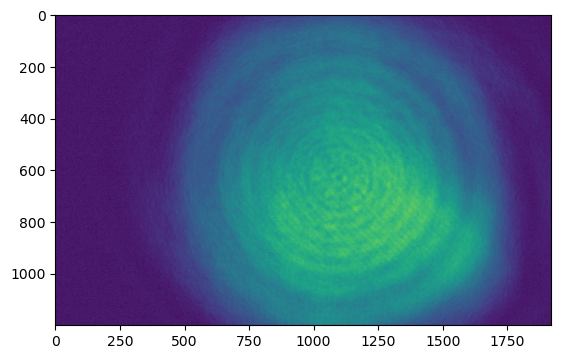

In [5]:
import numpy as np
import matplotlib.pyplot as plt

img = np.array(res.Array) # Store the image we grabbed as an array of pixel values
# Show image
plt.imshow(img)
plt.show()

## Calculations

In [6]:
# Constants
c = 3e8

# Wavelengths and frequnecies in HeNe
wavelengths_m = np.linspace(632e-9, 634e-9, 3)
frequencies_Hz = c / wavelengths_m
time_delays_s = 1 / frequencies_Hz

# Sampling rate calculation
sampling_rate_Hz = 2 * max(frequencies_Hz)

print("Appropriate sample rate is ", sampling_rate_Hz)

step_m = c / sampling_rate_Hz

print("Appropriate displacement step is ", step_m)

Appropriate sample rate is  949367088607594.9
Appropriate displacement step is  3.16e-07


## First scan

### Collect data

In [23]:
displacements_um = np.linspace(0, 3, 100) # Array of 100 displacement positions between 0 um and 3 um
data = displacements_um*0 # Array of zeros same size as displacements array
for i_d in range(len(displacements_um)):
    pitools.moveandwait(pidevice, '1',displacements_um[i_d]) # Move to each position in displacement array
    res = cam.GrabOne(1000) # Capture picture
    img = np.array(res.Array) # Store the picture's pixel values in an array
    #data[i_d] = img[1000,500]
    data[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    

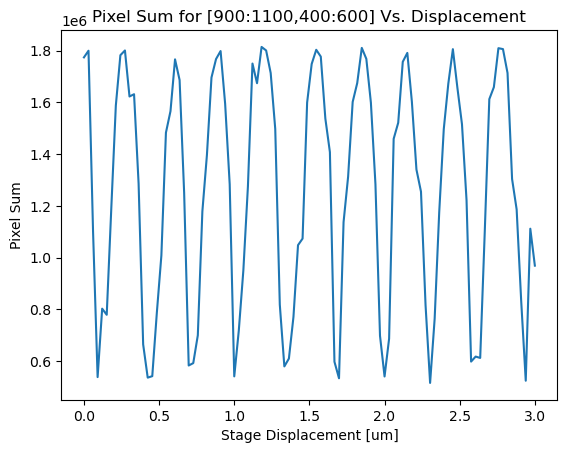

In [24]:
plt.plot(displacements_um, data)
plt.xlabel('Stage Displacement [um]')
plt.ylabel('Pixel Sum')
plt.title('Pixel Sum for [900:1100,400:600] Vs. Displacement')
plt.show()

C:\Users\opticslab\AppData\Local\Temp\ipykernel_2884\89565891.py:12: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths_m = c/positive_frequencies_Hz


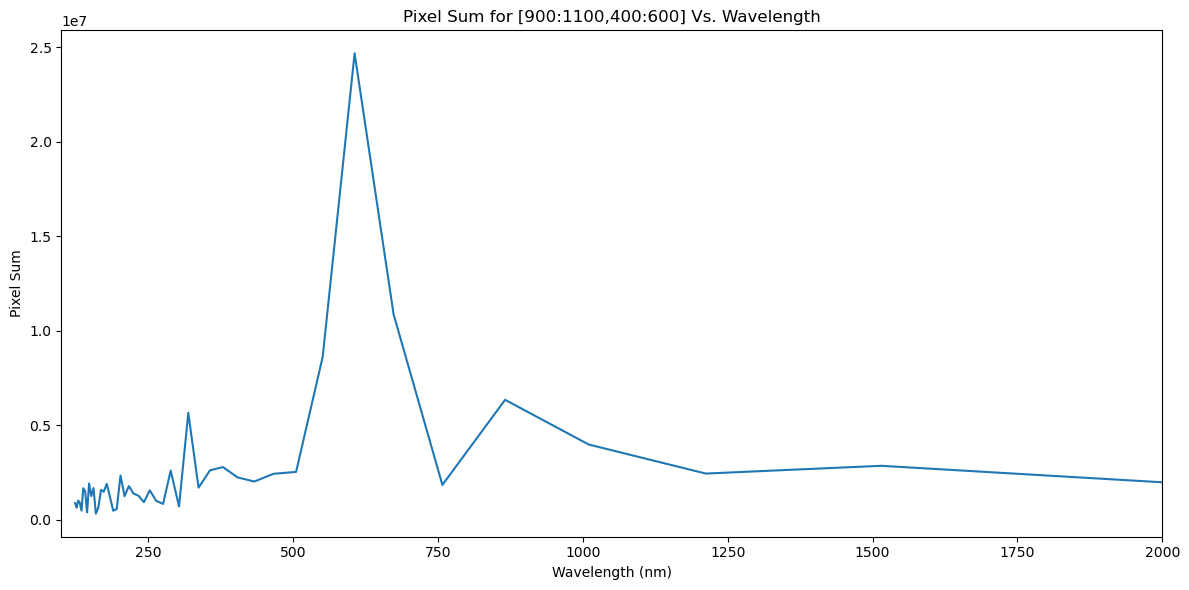

In [31]:
fourier_transform = np.fft.fft(data) # Perform FFT of data
period_s = (2 * (displacements_um[1] - displacements_um[0])* 1e-6) / c # Assuming uniform spacing
freq_Hz = np.fft.fftfreq(len(data), d=period_s)

# 3. Compute magnitude spectrum
magnitude = np.abs(fourier_transform)

# 4. Select only positive frequencies and their magnitudes
positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
positive_magnitude = magnitude[freq_Hz >= 0]

wavelengths_m = c/positive_frequencies_Hz

# 5. Plot the results
plt.figure(figsize=(12, 6))

# Plot magnitude spectrum of positive frequencies
plt.plot(wavelengths_m*1e9, positive_magnitude)
plt.title('Pixel Sum for [900:1100,400:600] Vs. Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Pixel Sum')
plt.xlim((100, 2000))
#plt.xlim((630, 640))

plt.tight_layout()
plt.show()

### Scan 2

In [25]:
displacements1_um = np.linspace(0, 30, 1000) # Create a set of 500 displacements
data1 = displacements1_um*0 # Array of zeros same size as displacements array
for i_d in range(len(displacements1_um)):
    pitools.moveandwait(pidevice, '1',displacements1_um[i_d])
    res = cam.GrabOne(1000) # Capture picture
    img = np.array(res.Array) # Store the picture's pixel values in an array
    data1[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    

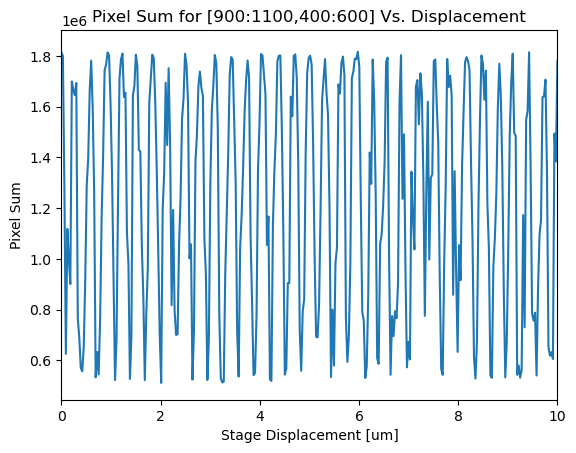

In [26]:
plt.plot(displacements1_um, data1)
plt.xlabel('Stage Displacement [um]')
plt.ylabel('Pixel Sum')
plt.title('Pixel Sum for [900:1100,400:600] Vs. Displacement')
plt.xlim((0,10))
plt.show()

### Fourier Transfrom of Data from Scan 2

C:\Users\opticslab\AppData\Local\Temp\ipykernel_2884\413266908.py:12: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths_m = c/positive_frequencies_Hz


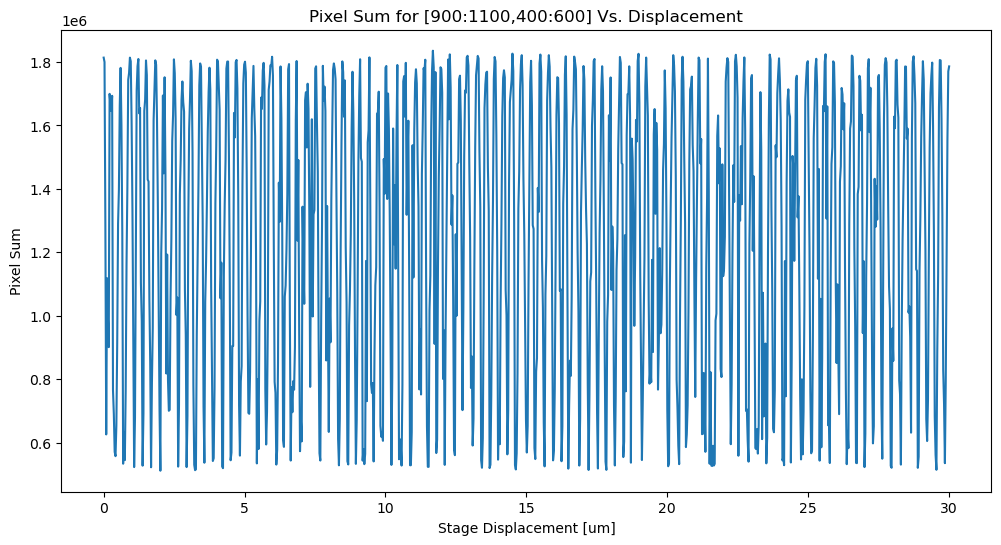

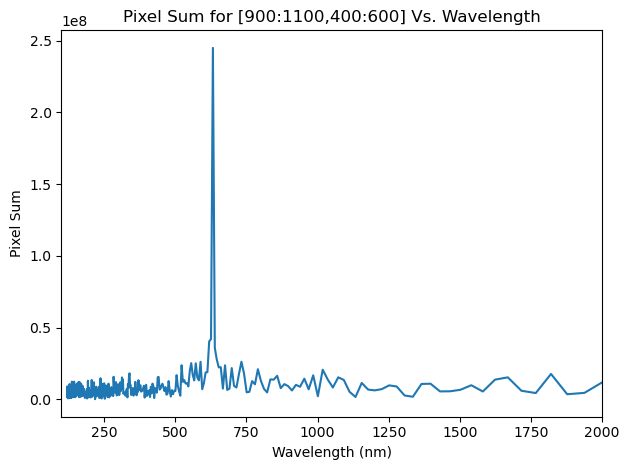

In [27]:

fourier_transform = np.fft.fft(data1) # Perform FFT of data
period_s = (2 * (displacements1_um[1] - displacements1_um[0])* 1e-6) / c # Assuming uniform spacing
freq_Hz = np.fft.fftfreq(len(data1), d=period_s)

# 3. Compute magnitude spectrum
magnitude = np.abs(fourier_transform)

# 4. Select only positive frequencies and their magnitudes
positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
positive_magnitude = magnitude[freq_Hz >= 0]

wavelengths_m = c/positive_frequencies_Hz

# 5. Plot the results
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(displacements1_um, data1)
plt.xlabel('Stage Displacement [um]')
plt.ylabel('Pixel Sum')
plt.title('Pixel Sum for [900:1100,400:600] Vs. Displacement')
plt.show()

# Plot magnitude spectrum of positive frequencies
plt.plot(wavelengths_m*1e9, positive_magnitude)
plt.title('Pixel Sum for [900:1100,400:600] Vs. Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Pixel Sum')
plt.xlim((100, 2000))
#plt.xlim((630, 640))

plt.tight_layout()
plt.show()


### Scan 3

In [28]:
displacements4_um = np.linspace(0, 360, 12000) # Create a set of 3000 displacements
data4 = displacements4_um*0 # Array of zeros same size as displacements array
for i_d in range(len(displacements4_um)):
    pitools.moveandwait(pidevice, '1',displacements4_um[i_d])
    res = cam.GrabOne(1000) # Capture picture
    img = np.array(res.Array) # Store the picture's pixel values in an array
    data4[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    

C:\Users\opticslab\AppData\Local\Temp\ipykernel_2884\3508451237.py:12: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths_m = c/positive_frequencies_Hz


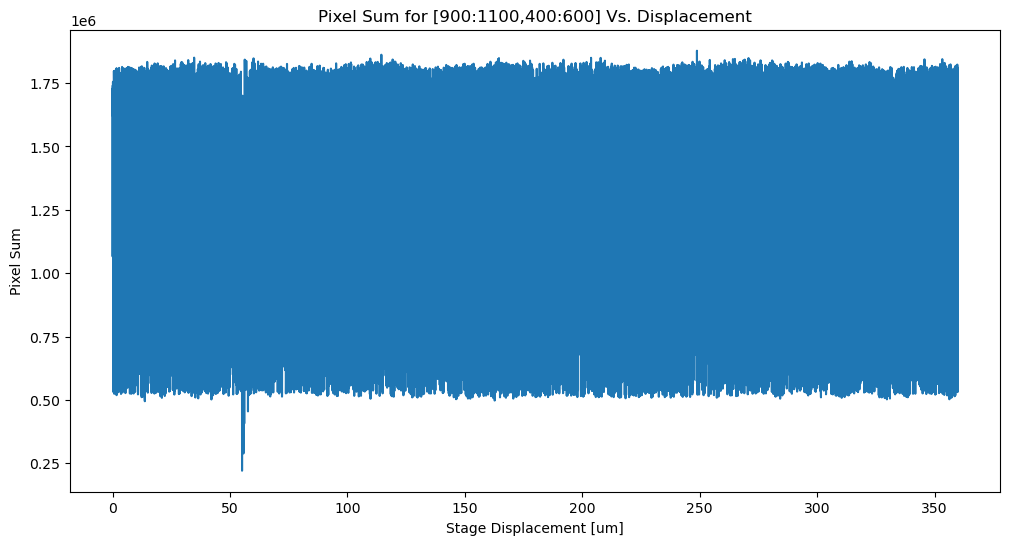

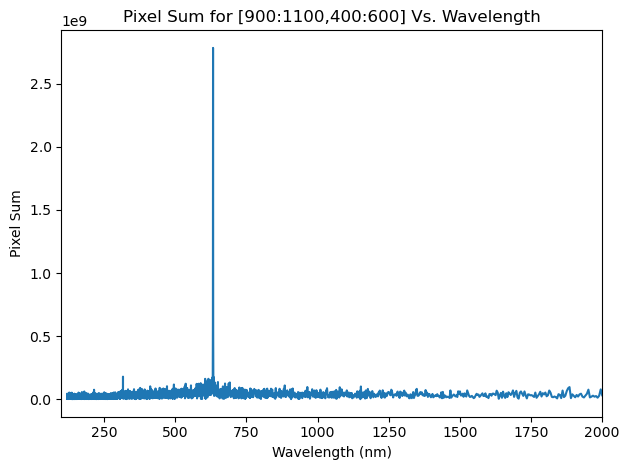

In [29]:
fourier_transform4 = np.fft.fft(data4) # Perform FFT of data
period_s = (2 * (displacements4_um[1] - displacements4_um[0])* 1e-6) / c # Assuming uniform spacing
freq_Hz = np.fft.fftfreq(len(data4), d=period_s)

# 3. Compute magnitude spectrum
magnitude = np.abs(fourier_transform4)

# 4. Select only positive frequencies and their magnitudes
positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
positive_magnitude = magnitude[freq_Hz >= 0]

wavelengths_m = c/positive_frequencies_Hz

# 5. Plot the results
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(displacements4_um, data4)
plt.xlabel('Stage Displacement [um]')
plt.ylabel('Pixel Sum')
plt.title('Pixel Sum for [900:1100,400:600] Vs. Displacement')
plt.show()

# Plot magnitude spectrum of positive frequencies
plt.plot(wavelengths_m*1e9, positive_magnitude)
plt.title('Pixel Sum for [900:1100,400:600] Vs. Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Pixel Sum')
plt.xlim((100, 2000))
#plt.xlim((630, 640))

plt.tight_layout()
plt.show()

### Jitter Test

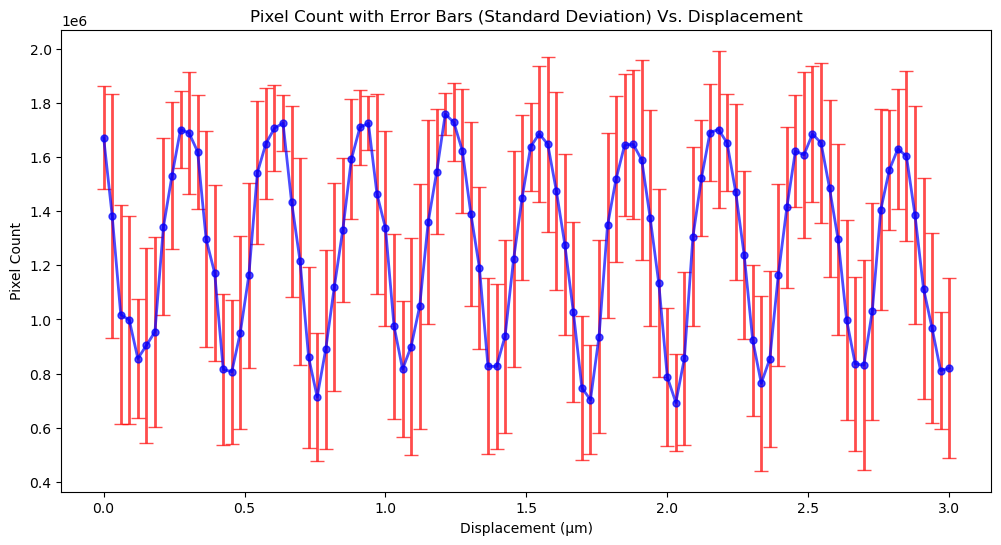

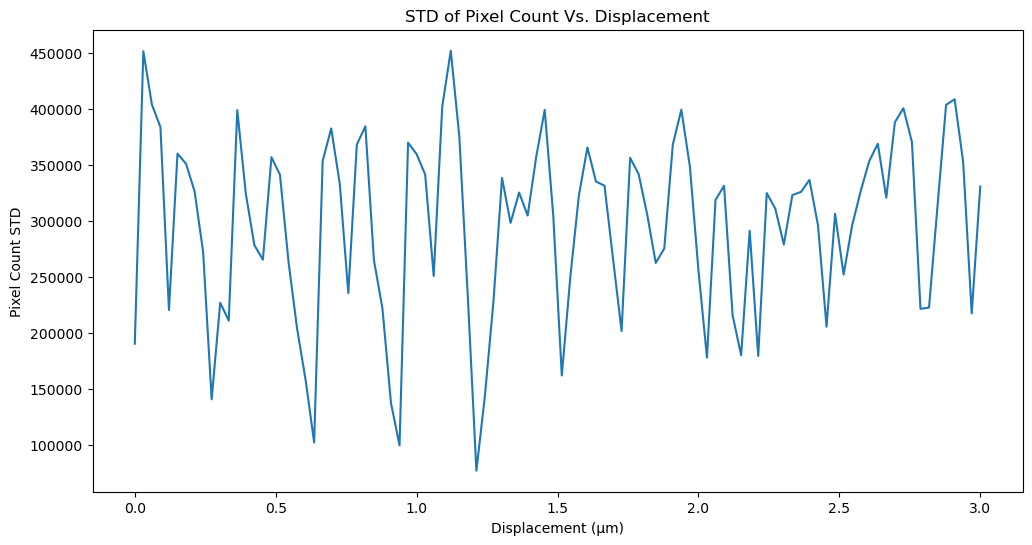

C:\Users\opticslab\AppData\Local\Temp\ipykernel_2884\2644384536.py:92: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths_m = c/positive_frequencies_Hz


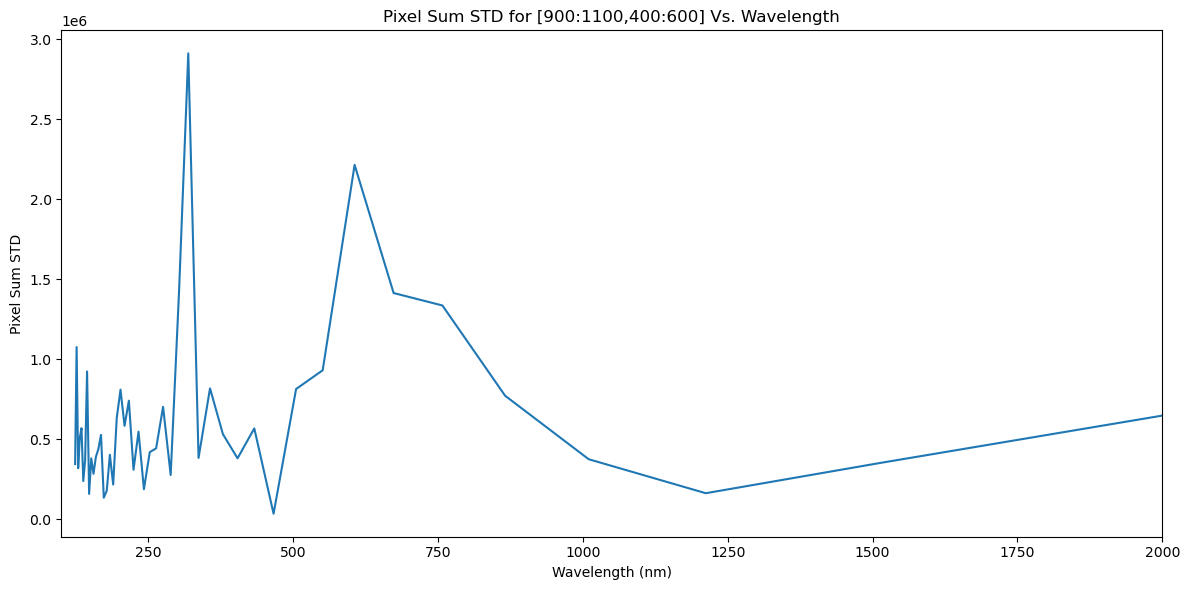

In [32]:
def scan(pidevice, cam, displacements):
    data = np.zeros_like(displacements)
    for i_d in range(len(displacements)):
        pitools.moveandwait(pidevice, '1',displacements[i_d])
        res = cam.GrabOne(1000) # Capture picture
        img = np.array(res.Array) # Store the picture's pixel values in an array
        data[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    return data

def collect_scans(pidevice, cam, displacements, N_scans):
    all_scans = []
    for _ in range(N_scans):
        scan_data = scan(pidevice, cam, displacements)
        all_scans.append(scan_data)
    return all_scans

def find_average(scan_data):
    average_scan = np.mean(scan_data, axis=0) # Average value for each element at a given index accross all the arrays
    return average_scan

def find_std(scan_data):
    average_scan = np.std(scan_data, axis=0) # Average value for each element at a given index accross all the arrays
    return average_scan

def test_scan(pidevice, cam, displacements):
    scan_data = scan(pidevice, cam, displacements)
    plt.figure(figsize=(12, 6))
    plt.plot(displacements, scan_data)
    plt.title('Original Data')
    plt.xlabel('Displacement (um)')
    plt.ylabel('Pixel Sum')
    plt.show()
    return scan_data

def test_collect_scans(pidevice, cam, displacements, N_scans):
    all_scans_pxcount = collect_scans(pidevice, cam, displacements, N_scans)
    for i in range(len(all_scans_pxcount)):
        '''
        plot_data = all_scans_pxcount[i]
        plt.figure(figsize=(12, 6))
        plt.plot(displacements, plot_data)
        plt.title('Original Data')
        plt.xlabel('Displacement (um)')
        plt.ylabel('Pixel Sum')
        plt.show()
        '''
    return all_scans_pxcount
        
def plot_pixel_count(averages, stds, displacements):
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.errorbar(
        displacements,
        averages,
        yerr=stds,
        capsize=5,  # Increase cap size for better visibility
        linestyle='-',  # Solid line
        marker='o',  # Add markers to data points
        markersize=5,  # Increase marker size
        linewidth=2,  # Increase line width
        color='blue',  # Change line color
        ecolor='red',  # Change error bar color
        elinewidth=2,  # Increase error bar line width
        alpha=0.7  # Set transparency for better visualization
    )
    plt.xlabel('Displacement (μm)')
    plt.ylabel('Pixel Count')
    plt.title('Pixel Count with Error Bars (Standard Deviation) Vs. Displacement')
    plt.show()

def plot_std(stds, displacements):
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(displacements, stds)
    plt.xlabel('Displacement (μm)')
    plt.ylabel('Pixel Count STD')
    plt.title('STD of Pixel Count Vs. Displacement')
    plt.show()

def plot_fft(stds, displacements):
    fourier_transform4 = np.fft.fft(stds) # Perform FFT of data
    period_s = (2 * (displacements[1] - displacements[0])* 1e-6) / c # Assuming uniform spacing
    freq_Hz = np.fft.fftfreq(len(stds), d=period_s)

    # 3. Compute magnitude spectrum
    magnitude = np.abs(fourier_transform4)

    # 4. Select only positive frequencies and their magnitudes
    positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
    positive_magnitude = magnitude[freq_Hz >= 0]

    wavelengths_m = c/positive_frequencies_Hz

    # 5. Plot the results
    plt.figure(figsize=(12, 6))

    # Plot magnitude spectrum of positive frequencies
    plt.plot(wavelengths_m*1e9, positive_magnitude)
    plt.title('Pixel Sum STD for [900:1100,400:600] Vs. Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Pixel Sum STD')
    plt.xlim((100, 2000))
    #plt.xlim((630, 640))

    plt.tight_layout()
    plt.show()

def test_find_average(scan_data):
    averages = find_average(scan_data)
    #print(averages)
    return averages

def test_find_std(scan_data):
    stds = find_std(scan_data)
    #print(stds)
    return stds


def run_jitter_tests(pidevice, cam, displacements, N_scans):
    scan_data = test_collect_scans(pidevice, cam, displacements, N_scans)
    scan_data_array = np.array(scan_data)
    averages = test_find_average(scan_data_array)
    stds = test_find_std(scan_data_array)
    plot_pixel_count(averages, stds, displacements)
    plot_std(stds, displacements)
    plot_fft(stds, displacements)
    

N_scans = 25 # Perform 100 scans
displacements5_um = np.linspace(0, 3, 100) # Create a set of 100 displacements between 0 um and 3 um
# all_scans_pxcount = [] # Store data from each scan

run_jitter_tests(pidevice, cam, displacements5_um, N_scans)

### Noise Tests

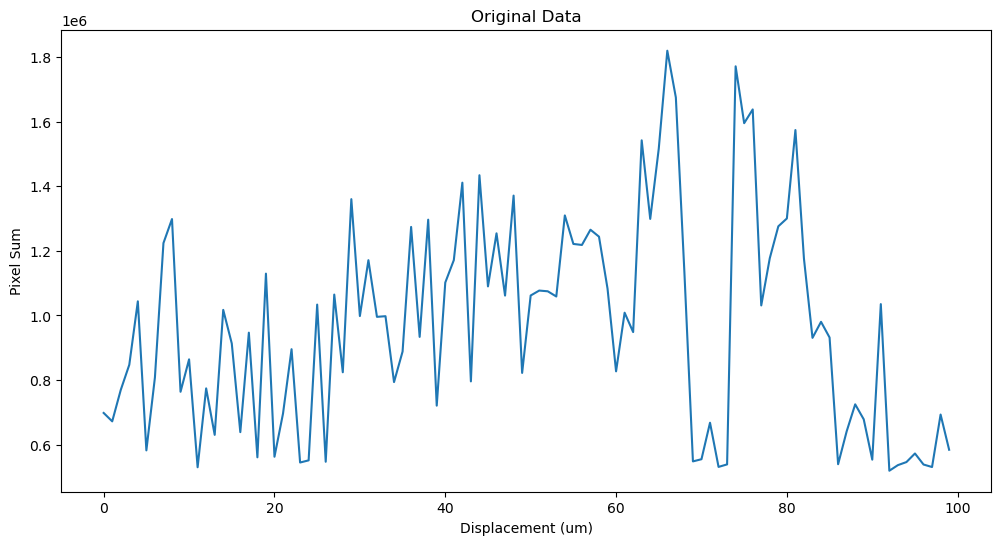

In [38]:
def noise_scan(pidevice, cam, displacement_offset, N_reads):
    data = np.arange(N_reads)*0
    pitools.moveandwait(pidevice, '1', displacement_offset)
    for i_d in range(N_reads):
        res = cam.GrabOne(1000) # Capture picture
        img = np.array(res.Array) # Store the picture's pixel values in an array
        data[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    return data

def test_noise_scan(pidevice, cam, displacement_offset, N_reads):
    scans = noise_scan(pidevice, cam, displacement_offset, N_reads)
    scan_number = np.arange(N_reads)
    plt.figure(figsize=(12, 6))
    plt.plot(scan_number, scans)
    plt.title('Original Data')
    plt.xlabel('Scan Number')
    plt.ylabel('Pixel Sum')
    plt.show()
    return scans

def run_noise_tests(pidevice, cam, displacement_offset, N_reads):
    test_noise_scan(pidevice, cam, displacement_offset, N_reads)

run_noise_tests(pidevice, cam, 10, 100)


### Close Camera

In [23]:
cam.Close() # Close connection to camera